In [55]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from scipy.optimize import curve_fit
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound

eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
hppc_DIR = "../data/hppc/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
resistance_DIR = "../data/resistance/"
# %matplotlib widget

In [56]:
cell = 16
sno = 7

parameter_values = get_parameter_values()

spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
        # "calculate discharge energy": "true"
    }
)
# spm.print_parameter_info()
param=spm.param

sim_des = f'cond{sno}'
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/100")
    ] *dfe.N.iloc[-1],
    # ] *1,
    termination="50% capacity",
#     cccv_handling="ode",
)

par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09]
# Using C/5, 2C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[6]=[2.9056e-07,2.6764e-06,1.3792,1.2686e-09]
# New Mech Damage Model with Lithium plating resistane
par_val[7]=[2.190e-07,2.308e-06,1.214,2.537e-09]

parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        # "Negative electrode diffusion coefficient [m2.s-1]":8.0E-15,
        # "Positive electrode diffusion coefficient [m2.s-1]":8.0E-16,
    },
    check_already_exists=False,
)

all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)


25


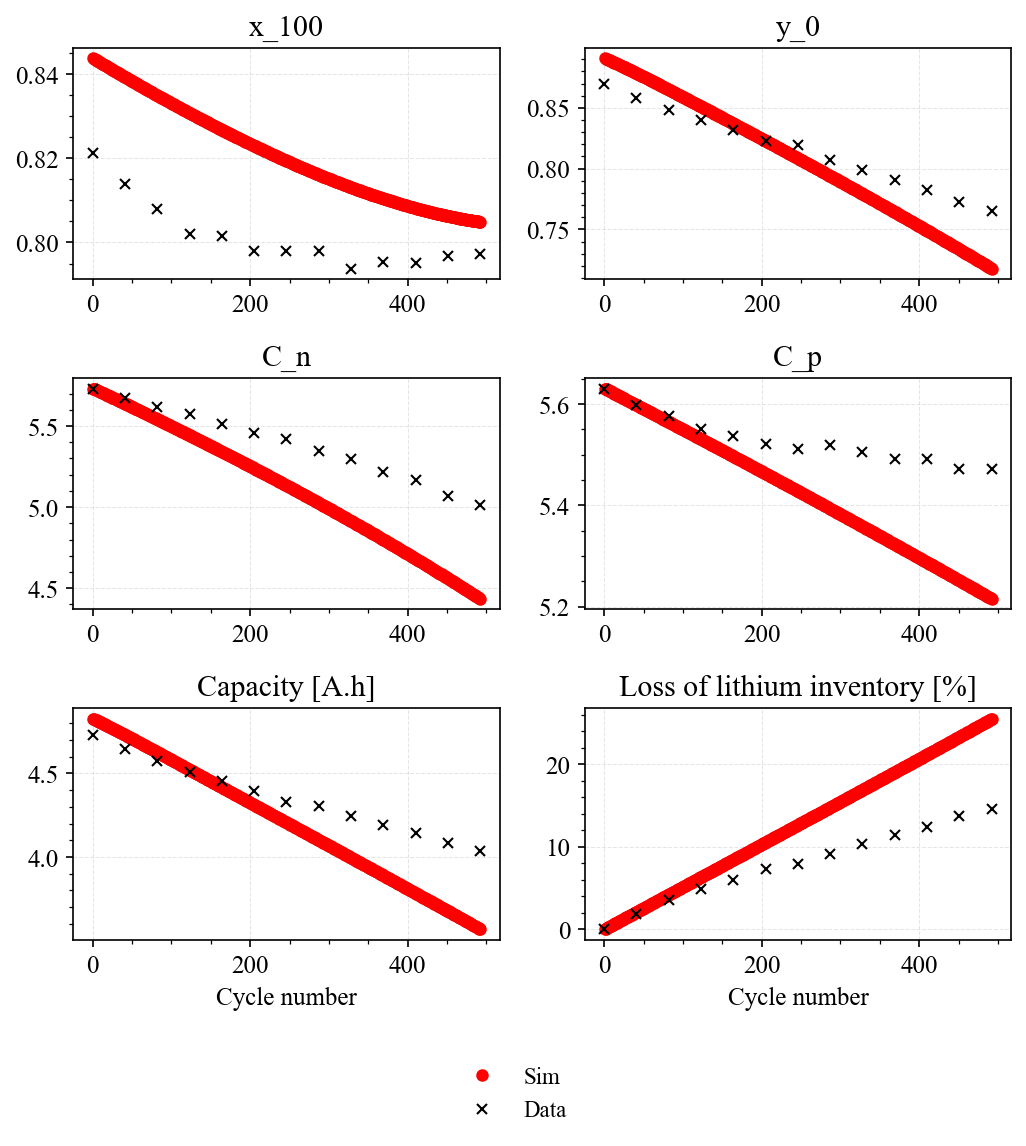

In [57]:
plotc(all_sumvars_dict,dfe);

In [58]:
t_in0 = 1
t_in1 = 1
t_inf = t_in0+t_in1
t_in = np.arange(0,t_inf,0.1)
# t_in = np.arange(0,t_inf,1)
# t_sim = np.arange(0,t_inf,0.01)
I_in = []
for tt in t_in:
    if tt<t_in0:
        I_in = np.append(I_in,0)
    elif tt>=t_in0 and tt<t_in0+t_in1:
        I_in = np.append(I_in,5)
# I_in = np.array([0,0,5,5,0,0,-5,-5,0,0])
timescale = parameter_values.evaluate(spm.timescale)

def get_pulse_res(parameter_values,esoh_sol,SOC):
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    x_0 = esoh_sol["x_0"].data[0]
    y_0 = esoh_sol["y_0"].data[0]
    cs_n_0 = (SOC*(x_100-x_0)+x_0)*c_n_max
    cs_p_0 = (SOC*(y_100-y_0)+y_0)*c_p_max
    parameter_values.update(
      {
          "Initial concentration in negative electrode [mol.m-3]": cs_n_0,
          "Initial concentration in positive electrode [mol.m-3]": cs_p_0,        
      }
    )
    sim_pulse = pybamm.Simulation(spm, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1))
    sol_pulse = sim_pulse.solve(t_eval=t_in)
    I   =  sol_pulse["Current [A]"].entries
    Vt  =  sol_pulse["Terminal voltage [V]"].entries
    idx = np.where(np.diff(np.sign(-I)))[0]
    Rs = abs((Vt[idx+1]-Vt[idx])/(I[idx+1]-I[idx]))[0]
    return Rs

def get_Rs(cyc_no,eSOH,parameter_values):
  model = spm
  Vmin = 3.0
  Vmax = 4.2
  esoh_model = pybamm.lithium_ion.ElectrodeSOH()
  esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
  Cn = eSOH["C_n"][Ns[cyc_no]]
  Cp = eSOH["C_p"][Ns[cyc_no]]
  c_n_max = parameter_values.evaluate(param.n.prim.c_max)
  c_p_max = parameter_values.evaluate(param.p.prim.c_max)
  n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
  c_plated_Li = eSOH['X-averaged lithium plating concentration [mol.m-3]'][Ns[cyc_no]]
  eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
  eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
  del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
  esoh_sol = esoh_sim.solve(
      [0],
      inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
      solver=pybamm.AlgebraicSolver(),
  )
  parameter_values.update(
          {
              "Negative electrode active material volume fraction": eps_n_data,
              "Positive electrode active material volume fraction": eps_p_data,
              "Initial inner SEI thickness [m]": 0e-09,
              "Initial outer SEI thickness [m]": del_sei,
              "Initial plated lithium concentration [mol.m-3]": c_plated_Li,
          }
        )
  timescale = parameter_values.evaluate(spm.timescale)
  current_interpolant = pybamm.Interpolant(
    t_in, -I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_ch_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,esoh_sol,SOC)
      Rs_ch_s.append(Rs_t)
  Rs_ch = np.average(Rs_ch_s)
  
  current_interpolant = pybamm.Interpolant(
    t_in, I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_dh_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,esoh_sol,SOC)
      Rs_dh_s.append(Rs_t)
  Rs_dh = np.average(Rs_dh_s)
  Rs = (Rs_dh + Rs_ch)/2
  return Rs

i = 0
Rs = []
# for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in [0,len(N)-2]:
for cyc_no in range(len(Ns)):
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
    },
    check_already_exists=False,
    )
    Rs_t = get_Rs(cyc_no,all_sumvars_dict,parameter_values)
    Rs.append(Rs_t)



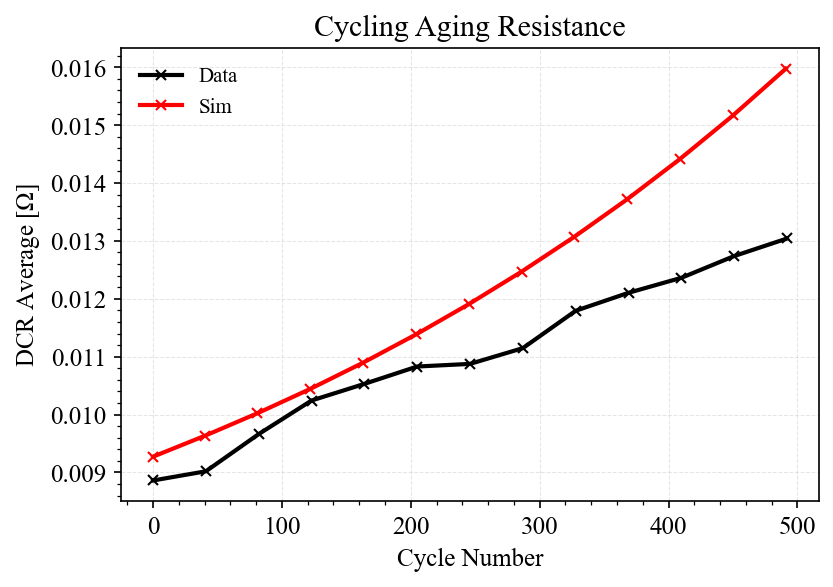

In [59]:
df = pd.DataFrame({'N': N,'Ah_th':dfe["Ah_th"]-dfe["Ah_th"][0], 'Rs_data': dfe["Rs_ave"],'Rs_sim':Rs,
                    })
df.to_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv", index=False)

fig, ax = plt.subplots(1,1)
ax.plot(dfe["N"],dfe["Rs_ave"],'kx-')
ax.plot(Ns,Rs,'rx-')
ax.set_xlabel('Cycle Number')
ax.set_ylabel(r'DCR Average [$\Omega$]')
ax.legend(['Data','Sim'])
ax.set_title("Cycling Aging Resistance")
# plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance.png')

In [60]:
def get_Rs_SOC(cyc_no,eSOH,parameter_values):
  model = spm
  Vmin = 3.0
  Vmax = 4.2
  esoh_model = pybamm.lithium_ion.ElectrodeSOH()
  esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
  Cn = eSOH["C_n"][Ns[cyc_no]]
      # print(Cn)
  Cp = eSOH["C_p"][Ns[cyc_no]]
  c_n_max = parameter_values.evaluate(param.n.prim.c_max)
  c_p_max = parameter_values.evaluate(param.p.prim.c_max)
  n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
  eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
  eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
  del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
  c_plated_Li = eSOH['X-averaged lithium plating concentration [mol.m-3]'][Ns[cyc_no]]
  esoh_sol = esoh_sim.solve(
      [0],
      inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
      solver=pybamm.AlgebraicSolver(),
  )
  parameter_values.update(
          {
              "Negative electrode active material volume fraction": eps_n_data,
              "Positive electrode active material volume fraction": eps_p_data,
              "Initial temperature [K]": 273.15+25,
              "Ambient temperature [K]": 273.15+25,
              "Initial inner SEI thickness [m]": 0e-09,
              "Initial outer SEI thickness [m]": del_sei,
              "Initial plated lithium concentration [mol.m-3]": c_plated_Li,
          }
        )
  timescale = parameter_values.evaluate(spm.timescale)
  current_interpolant = pybamm.Interpolant(
    t_in, -I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_ch_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,esoh_sol,SOC)
      Rs_ch_s.append(Rs_t)
  Rs_ch = np.average(Rs_ch_s)
  
  current_interpolant = pybamm.Interpolant(
    t_in, I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_dh_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,esoh_sol,SOC)
      Rs_dh_s.append(Rs_t)
  Rs_dh = np.average(Rs_dh_s)
  Rs = (Rs_dh + Rs_ch)/2
  Rs_ave_s = (np.array(Rs_dh_s)+np.array(Rs_ch_s))/2
  return Rs_ave_s,Rs_ch_s,Rs_dh_s

In [61]:
soc = np.linspace(0.9,0.1,9)

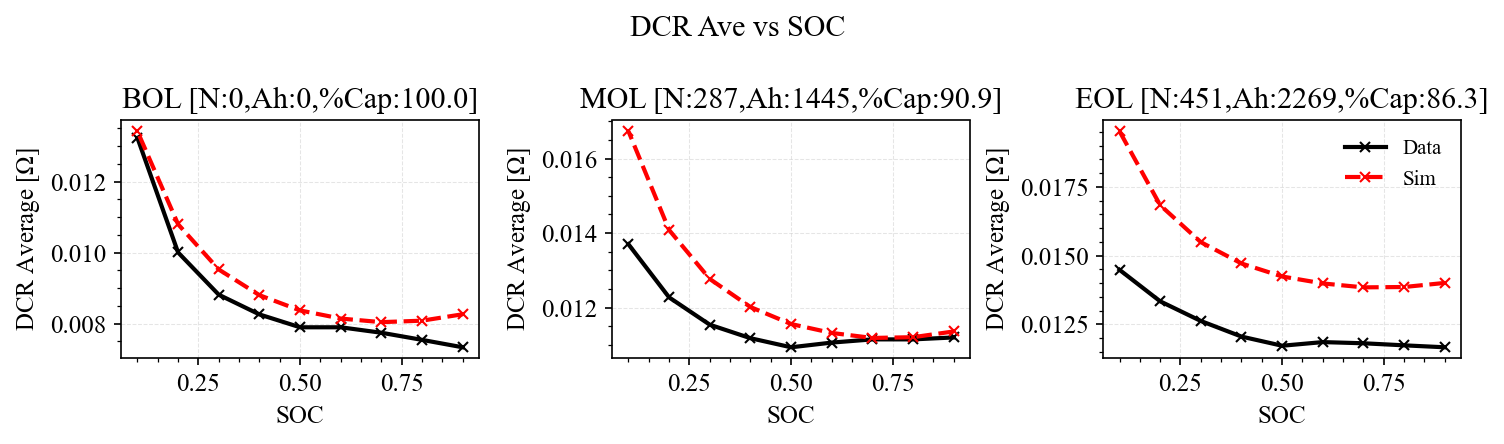

In [62]:
i=0
titles = ["BOL","MOL","EOL"]
fig, ax = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in [0]:
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    Rs_ave,Rs_ch,Rs_dh = get_Rs_SOC(cyc_no,all_sumvars_dict,parameter_values)
    res_data = pd.read_csv(resistance_DIR+'resistance_data_cell_'+cell_no+'.csv', header=None).to_numpy()
    res_data[res_data == 0] = 'nan'
    ax1 = ax.flat[i]
    ax1.plot(soc,res_data[cyc_no],'kx-')
    ax1.plot(soc,Rs_ave,'rx--')
    ax1.set_xlabel('SOC')
    ax1.set_ylabel(r'DCR Average [$\Omega$]')
    ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    i+=1
ax1.legend(["Data","Sim"])
fig.suptitle('DCR Ave vs SOC')
fig.tight_layout()
# ax.legend(['Data','Sim'])
# plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
plt.savefig(fig_DIR +'resistance_SOC_cell_'+cell_no+'.png')

# Plots all Cells

In [63]:
dfgdfgfd

NameError: name 'dfgdfgfd' is not defined

In [ ]:
cells = [1,4,7,10,13,16,19]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],df["Rs_data"],'k',linestyle="None",marker=markers[i])
    ax.plot(df["Ah_th"],df["Rs_sim"],'r',linestyle="None",marker=markers[i])
    i+=1
ax.set_xlabel('Cycle Number')
ax.set_ylabel(r'Resistance [$\Omega$]')
ax.set_title(r'Average DC Resistance')
ax.legend(['Data','Sim'])
# plt.savefig(fig_DIR +'cycling_aging_room_resistance.png')

In [ ]:
cells = [1,4,7,10,13,16,19]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],df["Rs_data"],linestyle="None",marker=markers[i],label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],df["Rs_sim"],color=colors[i])
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance [$\Omega$]')
ax.set_title(r'Average DC Resistance')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_resistance.png')

In [ ]:
cells = [1,4,7,10]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],df["Rs_data"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],df["Rs_sim"],color=colors[i])
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance [$\Omega$]')
ax.set_title(r'Average DC Resistance')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_resistance_s1_1.png')

In [ ]:
cells = [1,13,10,16]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],df["Rs_data"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],df["Rs_sim"],color=colors[i])
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance [$\Omega$]')
ax.set_title(r'Average DC Resistance')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Mixed Crate','Mixed 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_resistance_s1_2.png')

In [ ]:
cells = [13,16,19]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],df["Rs_data"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],df["Rs_sim"],color=colors[i])
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance [$\Omega$]')
ax.set_title(r'Average DC Resistance')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_resistance_s2_2.png')